In [1]:

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging


Using TensorFlow backend.


In [2]:
data= pd.read_excel('petroleo.xlsx', encoding='latin-1', sep=',')[::-1]
data= data[(data['fecha']>= '2002-01-01')]
data['var']= (data['var']*100)
df_train= data.iloc[:3138,:]
df_test = data.iloc[3138:,:]


train_cols = [ "ultimo" , "apertura" , "maximo" , "minimo" , "Vol",'var' ]
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])


In [821]:
params = {
    "batch_size": 60,  # 40(mejor) y 60 was a bust
    "epochs": 15,
    "lr": 0.00010000,
    "time_steps": 10
}

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [822]:

def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
# format time series
# [ batch_size, time_steps, Features ]
    

def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [823]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)


Are any NaNs present in train/test matrices? False False
dim_0 3128



length of time-series i/o (3128, 10, 6) (3128,)
Batch trimmed size (3120, 10, 6) (3120,)


In [824]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(70 , batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='he_uniform'))
    #lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    #lstm_model.add(Dropout(0.6))
    #lstm_model.add(Dense(40,activation='relu'))
    #lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(30,activation='relu'))
    #lstm_model.add(Dropout(0.6))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='linear'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [825]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


In [826]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Batch trimmed size",x_val.shape, y_val.shape)
print("Batch trimmed size",x_test_t.shape, y_test_t.shape)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 1335



length of time-series i/o (1335, 10, 6) (1335,)
Batch trimmed size (660, 10, 6) (660,)
Batch trimmed size (660, 10, 6) (660,)
Test size (660, 10, 6) (660,) (660, 10, 6) (660,)


In [827]:
stime = time.time()
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [828]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    # filepath='/tmp/weights.hdf5'
    mcp = ModelCheckpoint(os.path.join(os.getcwd(),"best_model.h5"),
                           monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
        
    #csv_logger = CSVLogger( , append=True)
    #csv_logger = CSVLogger(os.path.join('./deep-learning-project/', 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    csv_logger = CSVLogger('training.log', append=True)
    
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))
    
      
    

Building model...
checking if GPU available []
Train on 3120 samples, validate on 660 samples
Epoch 1/15
 - 61s - loss: 0.0254 - val_loss: 0.0618

Epoch 00001: val_loss improved from inf to 0.06178, saving model to C:\Users\User\Desktop\deep-learning-project\best_model.h5
Epoch 2/15
 - 5s - loss: 0.0144 - val_loss: 0.0171

Epoch 00002: val_loss improved from 0.06178 to 0.01711, saving model to C:\Users\User\Desktop\deep-learning-project\best_model.h5
Epoch 3/15
 - 5s - loss: 0.0046 - val_loss: 0.0031

Epoch 00003: val_loss improved from 0.01711 to 0.00310, saving model to C:\Users\User\Desktop\deep-learning-project\best_model.h5
Epoch 4/15
 - 5s - loss: 0.0032 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00310 to 0.00192, saving model to C:\Users\User\Desktop\deep-learning-project\best_model.h5
Epoch 5/15
 - 5s - loss: 0.0028 - val_loss: 0.0016

Epoch 00005: val_loss improved from 0.00192 to 0.00158, saving model to C:\Users\User\Desktop\deep-learning-project\best_model.h5

In [829]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0013763977865202373 (660,) (660,)
[0.28872243 0.28519237 0.28087547 0.2780999  0.27421132 0.26702923
 0.25564206 0.24977908 0.2487326  0.2561884  0.26847416 0.26426083
 0.27048418 0.27440616 0.27751085]
[0.27359017 0.27869506 0.28292255 0.27047938 0.26210417 0.26242323
 0.27335088 0.27454734 0.27550451 0.27343065 0.27335088 0.26369945
 0.26457685 0.26752812 0.27406876]


In [830]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[54.047134 53.60457  53.063362 52.715385 52.227875 51.327454 49.89985
 49.164803 49.033607 49.968338 51.508606 50.980385 51.760605 52.252304
 52.641533]
[52.15 52.79 53.32 51.76 50.71 50.75 52.12 52.27 52.39 52.13 52.12 50.91
 51.02 51.39 52.21]


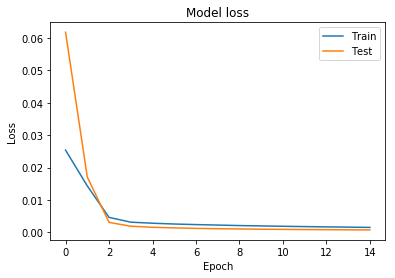

In [831]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [832]:
saved_model = load_model(os.path.join(os.getcwd(), 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
#print(saved_model)

In [833]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0014784750501341982 (660,) (660,)
[0.26494586 0.26313174 0.2598641  0.2558748  0.24817073 0.24012649
 0.22678992 0.22064143 0.21875983 0.22233725 0.23265564 0.22906667
 0.23465046 0.2393856  0.24491367]
[0.27359017 0.27869506 0.28292255 0.27047938 0.26210417 0.26242323
 0.27335088 0.27454734 0.27550451 0.27343065 0.27335088 0.26369945
 0.26457685 0.26752812 0.27406876]
[51.06626  50.83883  50.42916  49.929024 48.963165 47.95466  46.282654
 45.511818 45.27592  45.724422 47.01804  46.56809  47.268127 47.861774
 48.554825]
[52.15 52.79 53.32 51.76 50.71 50.75 52.12 52.27 52.39 52.13 52.12 50.91
 51.02 51.39 52.21]


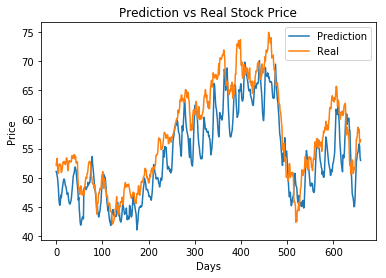

In [834]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')
plt.show()

ARIMA -LSTM

In [846]:
df = pd.read_excel('dataarimapred.xlsx', sep=',')
df['error']= (df['minimo']-df['pred'])
df.set_index ('fecha', inplace=True)
dftrain= df.iloc[:3138,3:4]
dftest= df.iloc[3138:,3:4]

In [897]:
traincols = ["error"]
# scale the feature MinMax, build array
x_error = dftrain.loc[:,traincols].values
min_max_scaler_error = MinMaxScaler()
xtrain = min_max_scaler_error.fit_transform(x_error)
xtest = min_max_scaler_error.transform(dftest.loc[:,traincols])

In [1066]:
params_error = {
    "batch_size": 70,  # 40(mejor) y 60 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 14
}

TIME_STEPS_error = params_error["time_steps"]
BATCH_SIZE_error = params_error["batch_size"]

In [1067]:

def trim_dataset_error(mat_error,batch_size_error):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop_error = mat_error.shape[0]%batch_size_error
    if no_of_rows_drop_error > 0:
        return mat_error[:-no_of_rows_drop_error]
    else:
        return mat_error
# format time series
# [ batch_size, time_steps, Features ]
    

def build_timeseries_error(mat_error, y_col_index_error):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0_error = mat_error.shape[0] - TIME_STEPS_error
    dim_1_error = mat_error.shape[1]
    x_error = np.zeros((dim_0_error, TIME_STEPS_error, dim_1_error))
    y_error = np.zeros((dim_0_error,))
    print("dim_0",dim_0_error)
    for i_error in tqdm_notebook(range(dim_0_error)):
        x_error[i_error] = mat_error[i_error:TIME_STEPS_error+i_error]
        y_error[i_error] = mat_error[TIME_STEPS_error+i_error, y_col_index_error]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x_error.shape,y_error.shape)
    return x_error, y_error

In [1068]:
print("Are any NaNs present in train/test matrices?",np.isnan(xtrain).any(), np.isnan(xtrain).any())
x_t_error, y_t_error = build_timeseries_error(xtrain, 0)
x_t_error = trim_dataset_error(x_t_error, BATCH_SIZE_error)
y_t_error = trim_dataset_error(y_t_error, BATCH_SIZE_error)
print("Batch trimmed size",x_t_error.shape, y_t_error.shape)

Are any NaNs present in train/test matrices? False False
dim_0 3124



length of time-series i/o (3124, 14, 1) (3124,)
Batch trimmed size (3080, 14, 1) (3080,)


In [1069]:
def create_model_error():
    lstm_model_error = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model_error.add(LSTM(90 , batch_input_shape=(BATCH_SIZE_error, TIME_STEPS_error, x_t_error.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='he_uniform'))
    #lstm_model_error.add(Dropout(0.4))
    lstm_model_error.add(LSTM(70, dropout=0.0))
    #lstm_model_error.add(Dropout(0.4))
    #lstm_model.add(Dense(40,activation='relu'))
    #lstm_model_error.add(Dropout(0.4))
    lstm_model_error.add(Dense(40,activation='relu'))
    #lstm_model_error.add(Dropout(0.4))
    #lstm_model_error.add(Dense(20,activation='relu'))
    lstm_model_error.add(Dense(1,activation='linear'))
    optimizer_error = optimizers.RMSprop(lr=params_error["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model_error.compile(loss='mean_squared_error', optimizer=optimizer_error)
    return lstm_model_error

In [1070]:
model_error = None
try:
    model_error = pickle.load(open("lstm_model_error", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Loaded saved model...


In [1071]:
x_temp_error, y_temp_error = build_timeseries_error(xtest, 0)
x_val_error, x_test_t_error = np.split(trim_dataset_error(x_temp_error, BATCH_SIZE_error),2)
y_val_error, y_test_t_error = np.split(trim_dataset_error(y_temp_error, BATCH_SIZE_error),2)
print("Batch trimmed size",x_val_error.shape, y_val_error.shape)
print("Batch trimmed size",x_test_t_error.shape, y_test_t_error.shape)

print("Test size", x_test_t_error.shape, y_test_t_error.shape, x_val_error.shape, y_val_error.shape)

dim_0 1331



length of time-series i/o (1331, 14, 1) (1331,)
Batch trimmed size (665, 14, 1) (665,)
Batch trimmed size (665, 14, 1) (665,)
Test size (665, 14, 1) (665,) (665, 14, 1) (665,)


In [1072]:
is_update_model_error = True
if model_error is None or is_update_model_error:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model_error = create_model_error()
    
    es_error = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    # filepath='/tmp/weights.hdf5'
    mcp_error = ModelCheckpoint(os.path.join(os.getcwd(),"best_model_error.h5"),
                           monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
        
    #csv_logger = CSVLogger( , append=True)
    #csv_logger = CSVLogger(os.path.join('./deep-learning-project/', 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    csv_logger_error = CSVLogger('training_error.log', append=True)
    
    
    history_error = model_error.fit(x_t_error, y_t_error, epochs=params_error["epochs"], verbose=2, batch_size=BATCH_SIZE_error,
                        shuffle=False, validation_data=(trim_dataset_error(x_val_error, BATCH_SIZE_error),
                        trim_dataset_error(y_val_error, BATCH_SIZE_error)), callbacks=[es_error, mcp_error, csv_logger_error])
    
    print("saving model...")
    pickle.dump(model_error, open("lstm_model_error", "wb"))
    

Building model...
checking if GPU available []
Train on 3080 samples, validate on 630 samples
Epoch 1/10
 - 107s - loss: 0.0415 - val_loss: 0.0033

Epoch 00001: val_loss improved from inf to 0.00326, saving model to C:\Users\User\Desktop\deep-learning-project\best_model_error.h5
Epoch 2/10
 - 7s - loss: 0.0049 - val_loss: 0.0040

Epoch 00002: val_loss did not improve from 0.00326
Epoch 3/10
 - 7s - loss: 0.0050 - val_loss: 0.0040

Epoch 00003: val_loss did not improve from 0.00326
Epoch 4/10
 - 7s - loss: 0.0049 - val_loss: 0.0041

Epoch 00004: val_loss did not improve from 0.00326
Epoch 5/10
 - 7s - loss: 0.0049 - val_loss: 0.0042

Epoch 00005: val_loss did not improve from 0.00326
Epoch 6/10
 - 7s - loss: 0.0049 - val_loss: 0.0041

Epoch 00006: val_loss did not improve from 0.00326
Epoch 7/10
 - 7s - loss: 0.0049 - val_loss: 0.0040

Epoch 00007: val_loss did not improve from 0.00326
Epoch 8/10
 - 7s - loss: 0.0049 - val_loss: 0.0040

Epoch 00008: val_loss did not improve from 0.00326

In [1073]:
y_pred_error = model_error.predict(trim_dataset(x_test_t_error, BATCH_SIZE_error), batch_size=BATCH_SIZE_error)
y_pred_error = y_pred_error.flatten()
y_test_t_error = trim_dataset(y_test_t_error, BATCH_SIZE_error)
error_error = mean_squared_error(y_test_t_error, y_pred_error)
print("Error is", error_error, y_pred_error.shape, y_test_t_error.shape)

Error is 0.002822904987758963 (630,) (630,)


In [1074]:
# convert the predicted value to range of real data
y_pred_org_error = (y_pred_error * min_max_scaler_error.data_range_[0]) + min_max_scaler_error.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org_error = (y_test_t_error * min_max_scaler_error.data_range_[0]) + min_max_scaler_error.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)

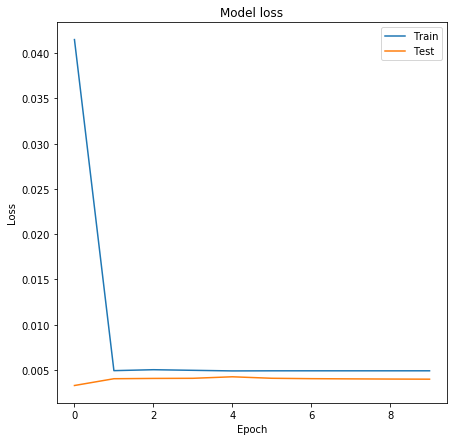

In [1075]:
plt.figure(figsize = (7,7))
plt.plot(history_error.history['loss'])
plt.plot(history_error.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [1011]:
saved_model_error = load_model(os.path.join(os.getcwd(), 'best_model_error.h5'))

In [1012]:
y_pred_error = saved_model_error.predict(trim_dataset(x_test_t_error, BATCH_SIZE_error), batch_size=BATCH_SIZE_error)
y_pred_error = y_pred_error.flatten()
y_test_t_error = trim_dataset(y_test_t_error, BATCH_SIZE_error)
error_error = mean_squared_error(y_test_t_error, y_pred_error)
print("Error is", error_error, y_pred_error.shape, y_test_t_error.shape)

y_pred_org_error = (y_pred_error * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org_error = (y_test_t_error * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0] # min_max_scaler.inverse_transform(y_test_t)



Error is 0.013922188327590606 (660,) (660,)


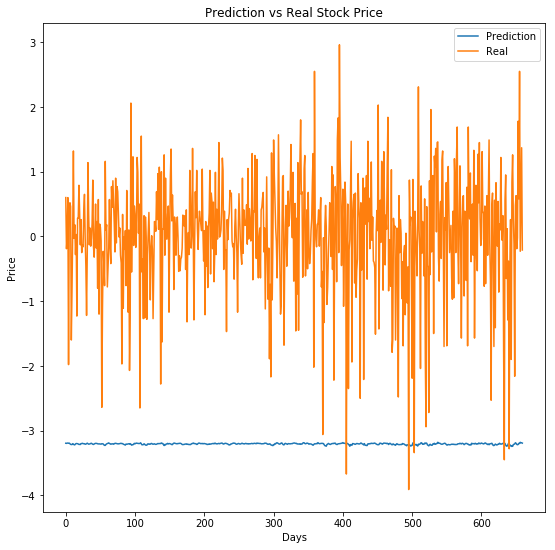

In [1026]:
plt.figure(figsize = (9,9))
plt.plot(y_pred_org_error)
plt.plot(y_test_t_org_error)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')
plt.show()

In [1035]:
#y_pred_error

In [1034]:
#y_test_t_error